In [1]:
!gdown 140cNIf_N_vA8u2zuxs8LmcwVx4uZsMxX

Downloading...
From (original): https://drive.google.com/uc?id=140cNIf_N_vA8u2zuxs8LmcwVx4uZsMxX
From (redirected): https://drive.google.com/uc?id=140cNIf_N_vA8u2zuxs8LmcwVx4uZsMxX&confirm=t&uuid=ca3074c3-31f6-4048-9bdf-dabefea2d1d8
To: /content/predict-energy-behavior-of-prosumers.zip
100% 242M/242M [00:04<00:00, 58.8MB/s]


In [2]:
!unzip *.zip

Archive:  predict-energy-behavior-of-prosumers.zip
  inflating: client.csv              
  inflating: county_id_to_name_map.json  
  inflating: electricity_prices.csv  
  inflating: forecast_weather.csv    
  inflating: gas_prices.csv          
  inflating: historical_weather.csv  
  inflating: train.csv               
  inflating: weather_station_to_county_mapping.csv  
  inflating: county_lon_lats.csv     


In [3]:
!pip install -q catboost optuna lightgbm xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.0 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import holidays
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import optuna
import joblib
from typing import Optional,Dict,Tuple
from pathlib import Path

sns.set_style()
plt.rcParams.update(**{'figure.dpi': 150})

In [5]:
data_path = Path('/content/')
df = pd.read_csv(data_path / 'train.csv', parse_dates=['datetime'])
df_clone = df.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   is_business         int64         
 2   product_type        int64         
 3   target              float64       
 4   is_consumption      int64         
 5   datetime            datetime64[ns]
 6   data_block_id       int64         
 7   row_id              int64         
 8   prediction_unit_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 138.6 MB


In [7]:
df.isna().sum()

,0
county,0
is_business,0
product_type,0
target,528
is_consumption,0
datetime,0
data_block_id,0
row_id,0
prediction_unit_id,0


In [8]:
df = df.dropna(how='any')
df.shape[0]

2017824

/tmp/ipython-input-9-310527774.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df, x = 'county', palette='viridis')


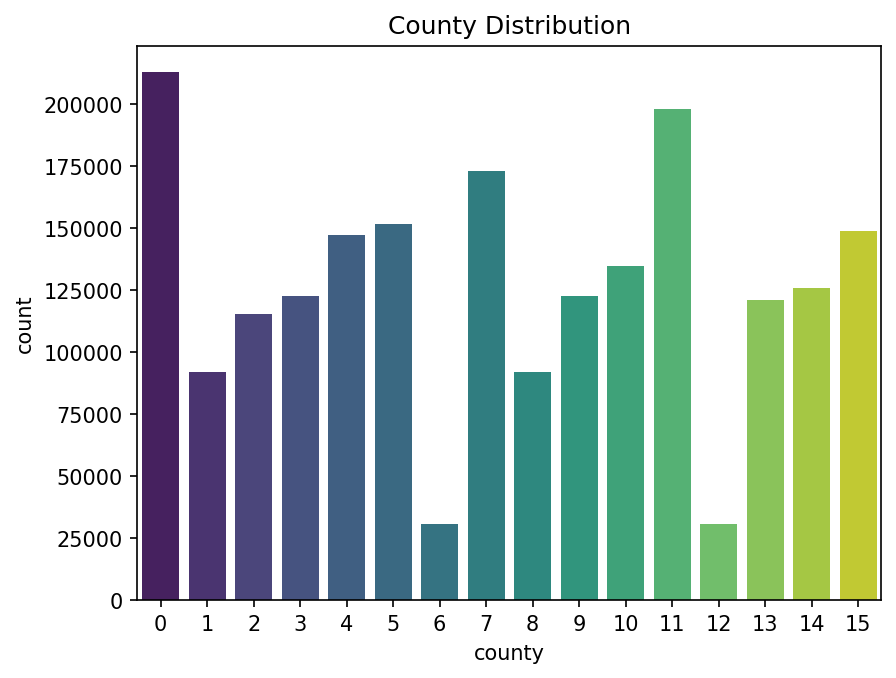

In [9]:
sns.countplot(df, x = 'county', palette='viridis')
plt.title('County Distribution')
plt.show()

/tmp/ipython-input-10-106292085.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_clone, x = 'temp', palette='viridis')


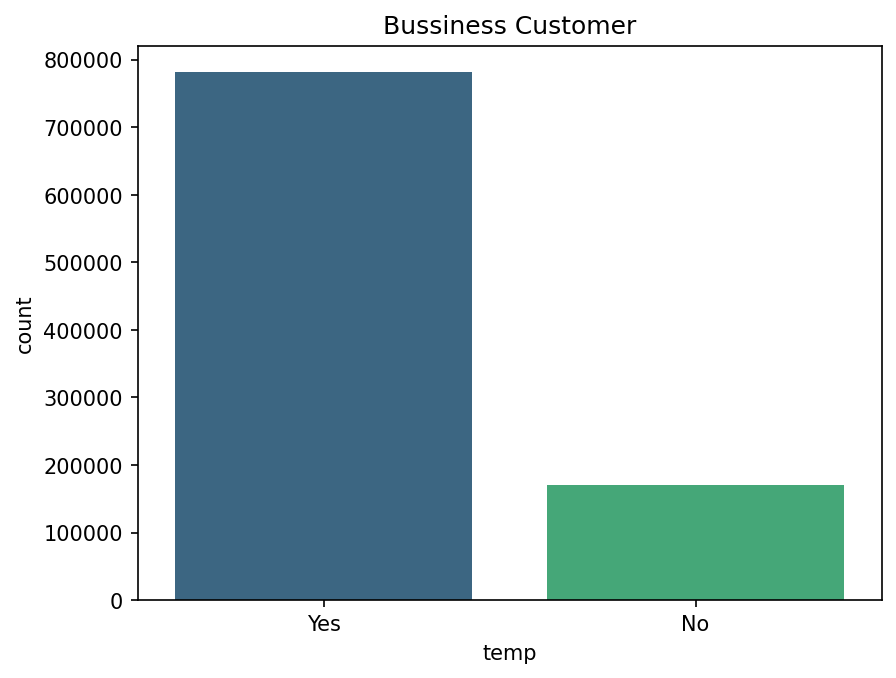

In [10]:
product_type_map = {0: "No", 1: "Yes"}
df_clone['temp'] = df_clone['product_type'].map(product_type_map)
sns.countplot(df_clone, x = 'temp', palette='viridis')
plt.title('Bussiness Customer')
plt.show()

/tmp/ipython-input-11-584802880.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_clone, x = 'temp', palette='viridis')


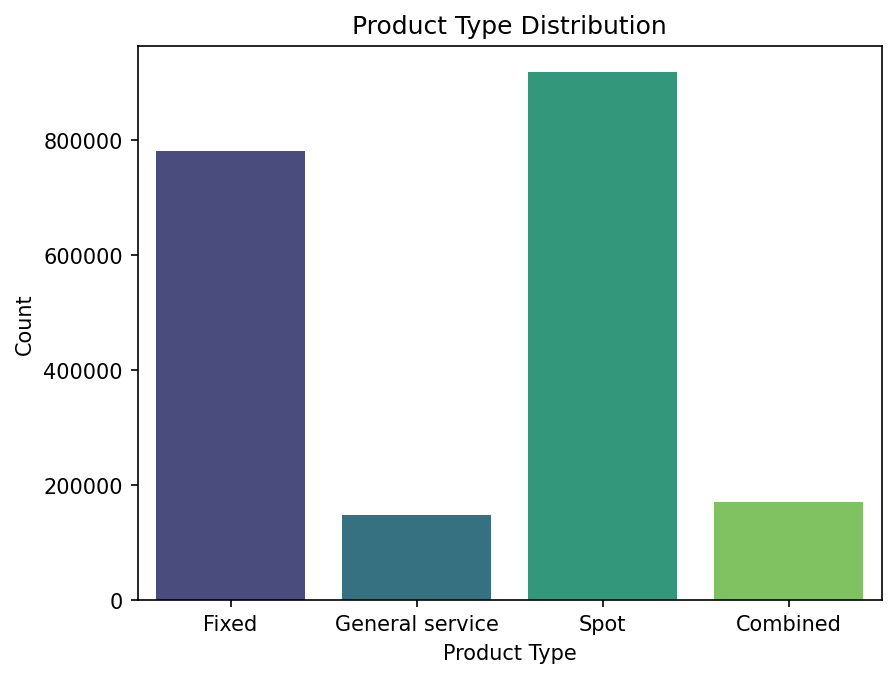

In [11]:
product_type_map = {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}
df_clone['temp'] = df_clone['product_type'].map(product_type_map)
sns.countplot(df_clone, x = 'temp', palette='viridis')
plt.title('Product Type Distribution')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.show()

/tmp/ipython-input-12-2498860382.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df_clone, x = 'temp', palette='viridis')


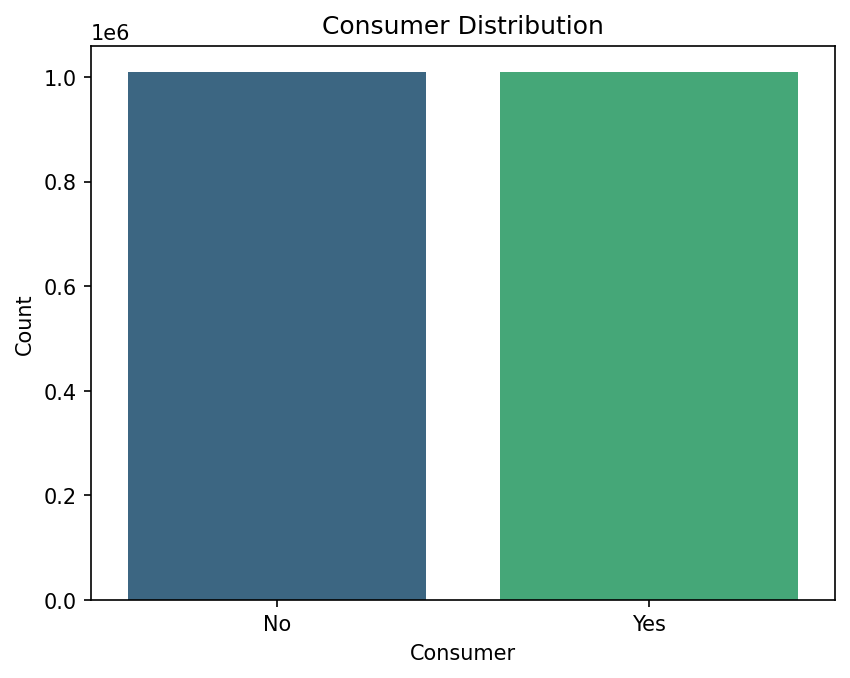

In [12]:
product_type_map = {0: "No", 1: "Yes"}
df_clone['temp'] = df_clone['is_consumption'].map(product_type_map)
sns.countplot(df_clone, x = 'temp', palette='viridis')
plt.title('Consumer Distribution')
plt.xlabel('Consumer')
plt.ylabel('Count')
plt.show()

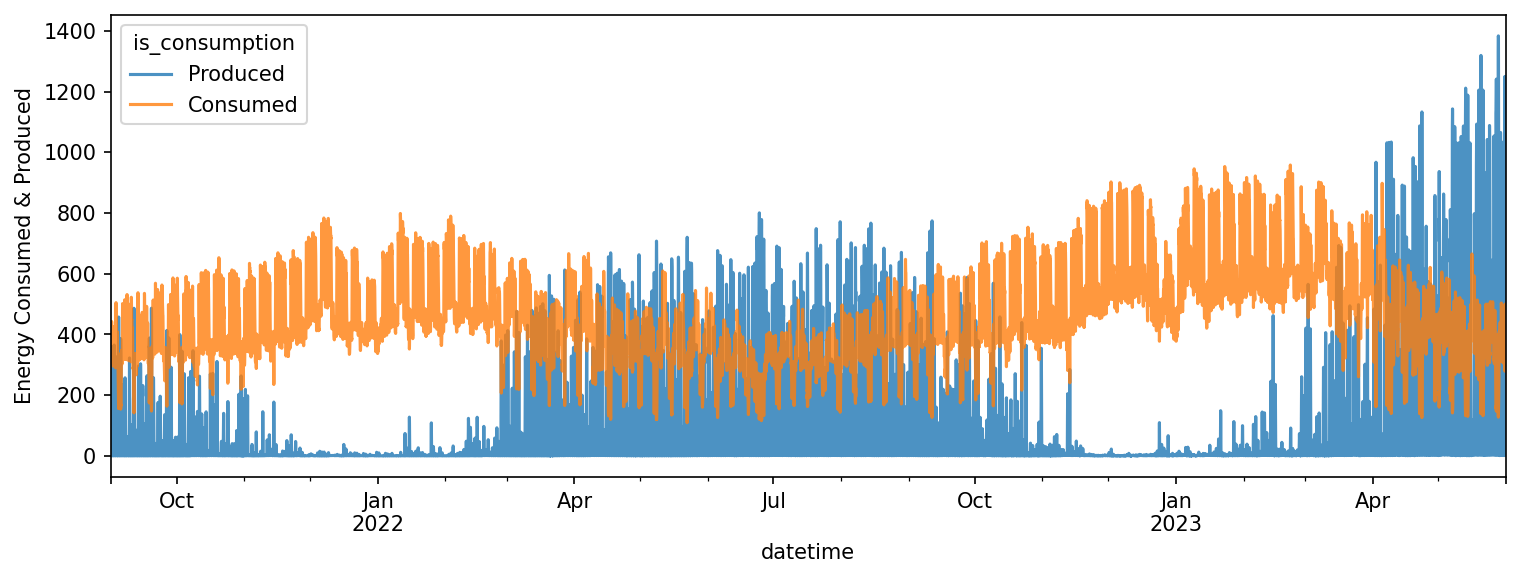

In [13]:
train_avgd = (
    df_clone
    .groupby(['datetime','is_consumption'])
    ['target'].mean()
    .unstack()
    .rename({0: 'Produced', 1:'Consumed'}, axis=1)
)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
_ = train_avgd.plot(ax=ax, alpha=0.8)
_ = ax.set_ylabel('Energy Consumed & Produced')

/tmp/ipython-input-14-496689030.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  _ = train_avgd.resample('M').mean().plot(ax=ax, marker='.')


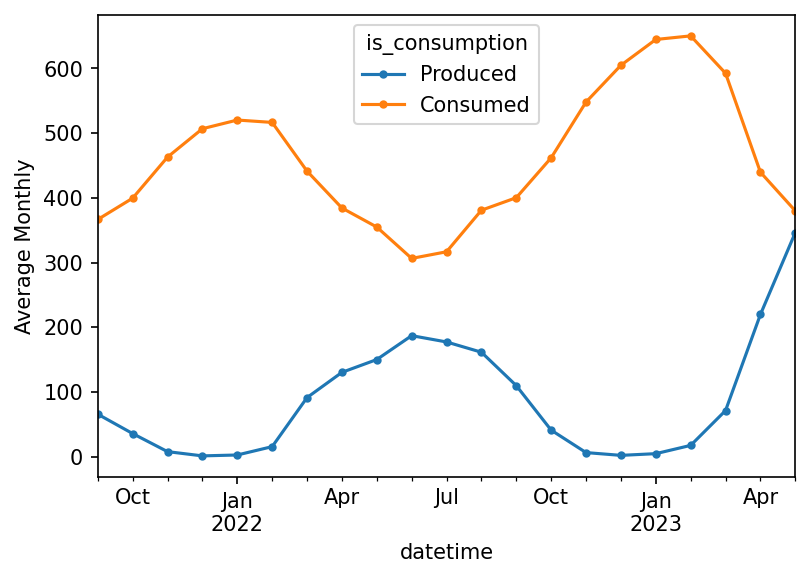

In [14]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
_ = train_avgd.resample('M').mean().plot(ax=ax, marker='.')
_ = ax.set_ylabel('Average Monthly')

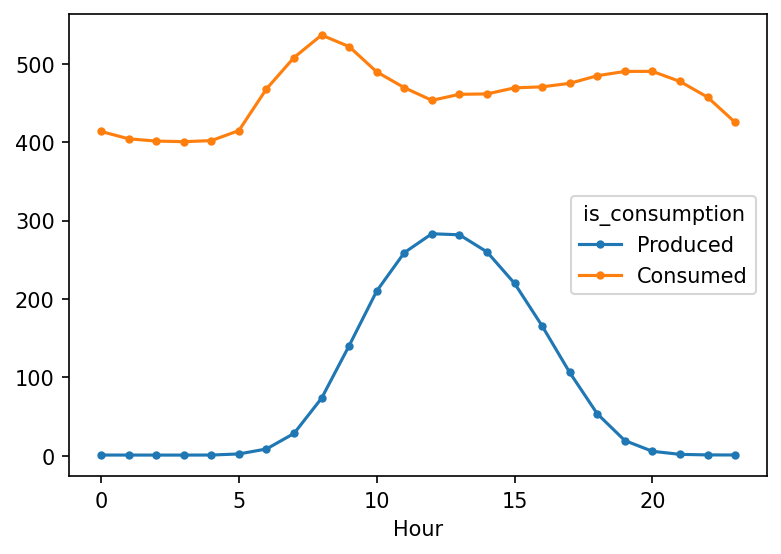

In [15]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
train_avgd.groupby(train_avgd.index.hour).mean().plot(ax=ax, marker='.')
_ = ax.set_xlabel('Hour')

In [16]:
earliest_time = df_clone['datetime'].min()

def extract_dt_attributes(df:pd.DataFrame):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['date'] = df['datetime'].dt.date
    df['time'] = df['datetime'].dt.strftime('%H:%M:%S')
    df['year'] = df['datetime'].dt.year
    df['datediff_in_days'] = (
        df['datetime']- earliest_time
    ).dt.days


    time_features = {
        'hour': [0, 23],
        'dayofweek': [0, 6],
        'week': [1, 52],
        'month': [1, 12]
    }

    for col in time_features:
        if col=='week':
            df[col] = df['datetime'].dt.isocalendar().week.astype(np.int32)
        else:
            df[col] = getattr(df['datetime'].dt,col)

        col_min,col_max = time_features[col]
        angles = 2*np.pi*(df[col]-col_min)/(col_max-col_min+1)

        df[col+'_sine'] = np.sin(angles).astype('float')
        df[col+'_cosine'] = np.cos(angles).astype('float')

In [17]:
extract_dt_attributes(df)

In [18]:
df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,hour_cosine,dayofweek,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine
0,0,0,1,0.713,0,2021-09-01,0,0,0,2021-09-01,...,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5
1,0,0,1,96.590,1,2021-09-01,0,1,0,2021-09-01,...,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5
2,0,0,2,0.000,0,2021-09-01,0,2,1,2021-09-01,...,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5
3,0,0,2,17.314,1,2021-09-01,0,3,1,2021-09-01,...,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5
4,0,0,3,2.904,0,2021-09-01,0,4,2,2021-09-01,...,1.0,2,0.974928,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5


In [19]:
shift = 2
df['data_block_id_shifted'] = df['data_block_id'] + shift

df = pd.merge(
    df,
    (
        df[[
            'county', 'is_business','is_consumption','product_type',
            'data_block_id_shifted', 'time', 'target']]
        .rename(columns={
            'data_block_id_shifted':'data_block_id',
            'target':f'target_{shift}days_ago'
        })
    ),
    on = ['county', 'is_business','is_consumption','product_type', 'data_block_id', 'time'],
    how='left'
)


del df['data_block_id_shifted']

In [20]:
df.tail(10)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,dayofweek,dayofweek_sine,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago
2017814,15,0,1,0.004,0,2023-05-31 23:00:00,637,2018342,57,2023-05-31,...,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,0.005
2017815,15,0,1,42.401,1,2023-05-31 23:00:00,637,2018343,57,2023-05-31,...,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,37.058
2017816,15,0,3,2.287,0,2023-05-31 23:00:00,637,2018344,58,2023-05-31,...,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,2.261
2017817,15,0,3,117.332,1,2023-05-31 23:00:00,637,2018345,58,2023-05-31,...,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,110.621
2017818,15,1,0,0.000,0,2023-05-31 23:00:00,637,2018346,64,2023-05-31,...,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,0.000
2017819,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,...,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,188.167
2017820,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,...,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,0.000
2017821,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,...,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,31.484
2017822,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,...,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,0.000
2017823,15,1,3,196.240,1,2023-05-31 23:00:00,637,2018351,60,2023-05-31,...,2,0.974928,-0.222521,22,0.568065,-0.822984,5,0.866025,-0.5,177.056


In [21]:
(
    df[['is_consumption', 'target', 'target_2days_ago']]
    .groupby('is_consumption')
    .corr()
    .round(3)
)

target  target_2days_ago
is_consumption                                           
0              target             1.000             0.822
               target_2days_ago   0.822             1.000
1              target             1.000             0.946
               target_2days_ago   0.946             1.000

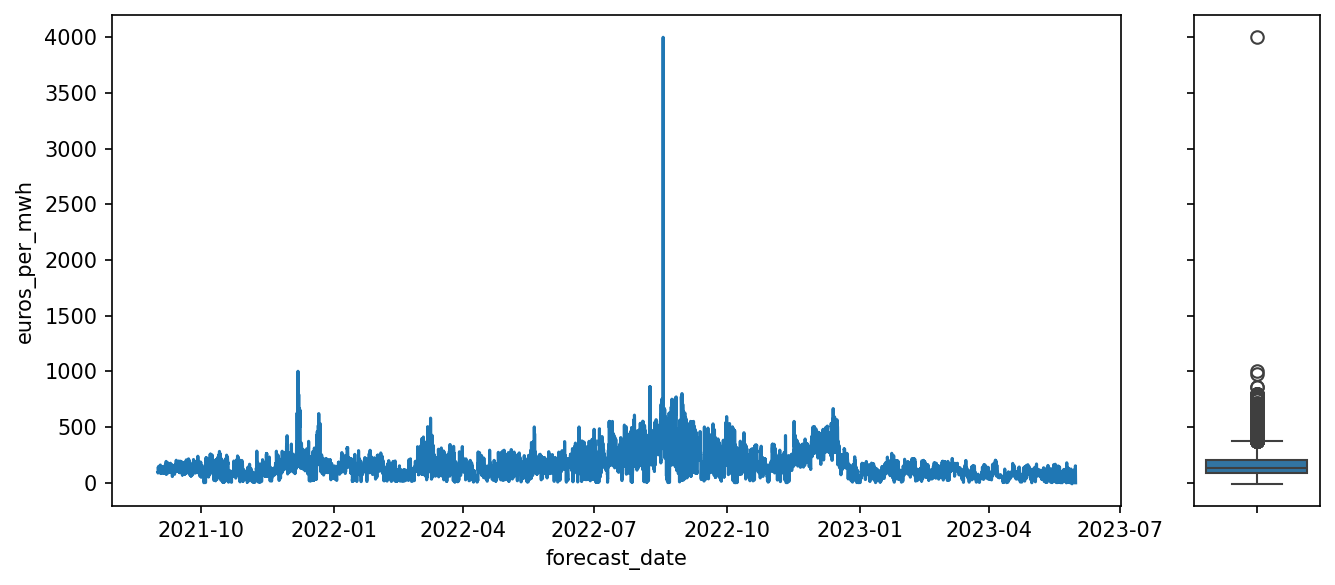

In [22]:
electricity_prices = pd.read_csv(data_path / 'electricity_prices.csv')
electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
electricity_prices['time'] = electricity_prices['forecast_date'].dt.strftime('%H:%M:%S')

fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(electricity_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(electricity_prices, y='euros_per_mwh', ax=axs[1])
#_ = axs[1].get_yaxis().set_visible(False)
fig.tight_layout()

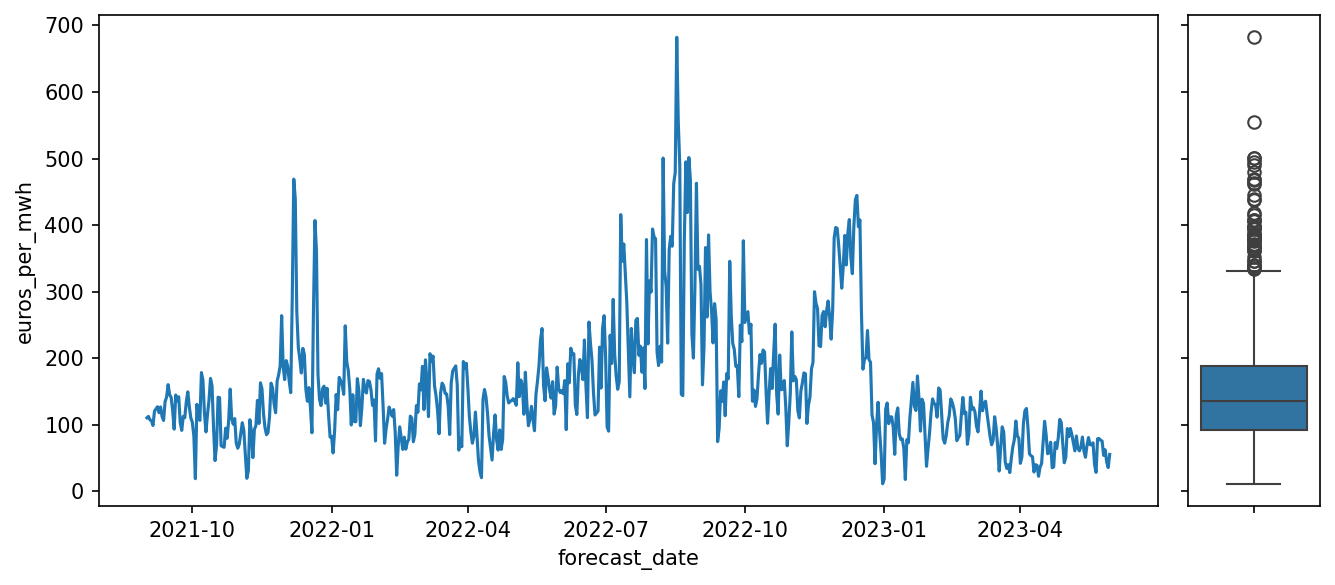

In [23]:
daily_elec_prices = (
    electricity_prices[['forecast_date', 'euros_per_mwh']]
    .set_index('forecast_date')
    .resample('D')
    .mean()
)

fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(daily_elec_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(daily_elec_prices, y='euros_per_mwh', ax=axs[1])
#_ = axs[1].get_yaxis().set_visible(False)
fig.tight_layout()

In [24]:
df = pd.merge(
    df,
    electricity_prices[['time', 'data_block_id', 'euros_per_mwh']],
    how = 'left',
    on = ['time', 'data_block_id']
)

In [25]:
gas_prices =  pd.read_csv(data_path / 'gas_prices.csv')
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])

gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


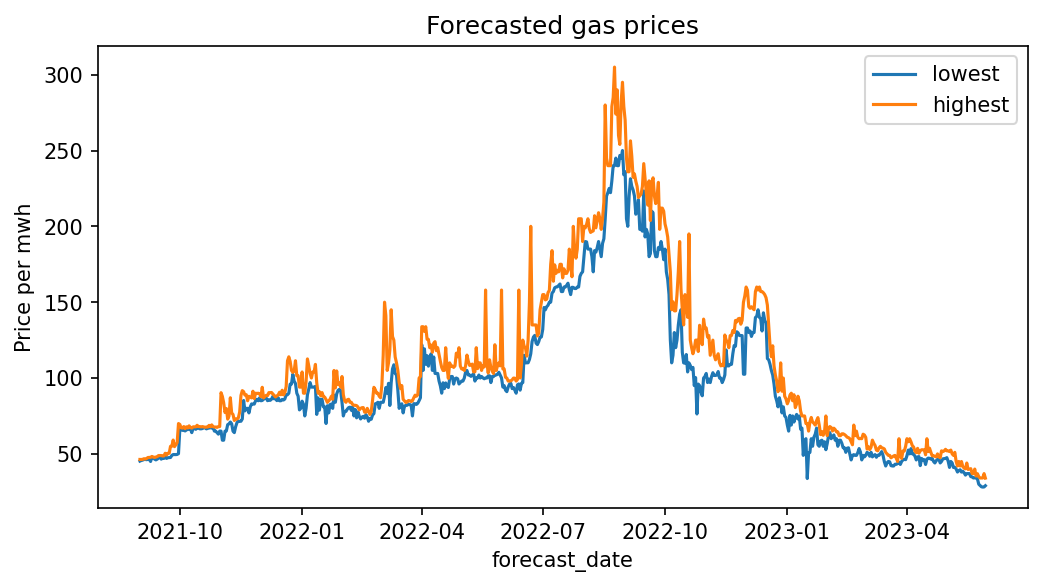

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
_ = sns.lineplot(gas_prices, x='forecast_date', y='lowest_price_per_mwh', ax=ax, label='lowest')
_ = sns.lineplot(gas_prices, x='forecast_date', y='highest_price_per_mwh', ax=ax, label='highest')
_ = ax.legend()
_ = ax.set_ylabel('Price per mwh')
_ = ax.set_title('Forecasted gas prices')

In [27]:
df = pd.merge(
    df,
    gas_prices[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']],
    how = 'left',
    on = ['data_block_id']
)

In [28]:
df.tail(10)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,week,week_sine,week_cosine,month,month_sine,month_cosine,target_2days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
2017814,15,0,1,0.004,0,2023-05-31 23:00:00,637,2018342,57,2023-05-31,...,22,0.568065,-0.822984,5,0.866025,-0.5,0.005,-1.29,29.0,34.0
2017815,15,0,1,42.401,1,2023-05-31 23:00:00,637,2018343,57,2023-05-31,...,22,0.568065,-0.822984,5,0.866025,-0.5,37.058,-1.29,29.0,34.0
2017816,15,0,3,2.287,0,2023-05-31 23:00:00,637,2018344,58,2023-05-31,...,22,0.568065,-0.822984,5,0.866025,-0.5,2.261,-1.29,29.0,34.0
2017817,15,0,3,117.332,1,2023-05-31 23:00:00,637,2018345,58,2023-05-31,...,22,0.568065,-0.822984,5,0.866025,-0.5,110.621,-1.29,29.0,34.0
2017818,15,1,0,0.000,0,2023-05-31 23:00:00,637,2018346,64,2023-05-31,...,22,0.568065,-0.822984,5,0.866025,-0.5,0.000,-1.29,29.0,34.0
2017819,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,...,22,0.568065,-0.822984,5,0.866025,-0.5,188.167,-1.29,29.0,34.0
2017820,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,...,22,0.568065,-0.822984,5,0.866025,-0.5,0.000,-1.29,29.0,34.0
2017821,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,...,22,0.568065,-0.822984,5,0.866025,-0.5,31.484,-1.29,29.0,34.0
2017822,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,...,22,0.568065,-0.822984,5,0.866025,-0.5,0.000,-1.29,29.0,34.0
2017823,15,1,3,196.240,1,2023-05-31 23:00:00,637,2018351,60,2023-05-31,...,22,0.568065,-0.822984,5,0.866025,-0.5,177.056,-1.29,29.0,34.0


In [29]:
client = pd.read_csv('client.csv')
# merge features
df = pd.merge(
    df,
    client.drop('date', axis=1),
    on = ['data_block_id', 'product_type', 'county', 'is_business'],
    how='left'
)

In [30]:
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [31]:
df.tail(10)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,...,week_cosine,month,month_sine,month_cosine,target_2days_ago,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
2017814,15,0,1,0.004,0,2023-05-31 23:00:00,637,2018342,57,2023-05-31,...,-0.822984,5,0.866025,-0.5,0.005,-1.29,29.0,34.0,51.0,415.60
2017815,15,0,1,42.401,1,2023-05-31 23:00:00,637,2018343,57,2023-05-31,...,-0.822984,5,0.866025,-0.5,37.058,-1.29,29.0,34.0,51.0,415.60
2017816,15,0,3,2.287,0,2023-05-31 23:00:00,637,2018344,58,2023-05-31,...,-0.822984,5,0.866025,-0.5,2.261,-1.29,29.0,34.0,161.0,2035.75
2017817,15,0,3,117.332,1,2023-05-31 23:00:00,637,2018345,58,2023-05-31,...,-0.822984,5,0.866025,-0.5,110.621,-1.29,29.0,34.0,161.0,2035.75
2017818,15,1,0,0.000,0,2023-05-31 23:00:00,637,2018346,64,2023-05-31,...,-0.822984,5,0.866025,-0.5,0.000,-1.29,29.0,34.0,15.0,620.00
2017819,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,...,-0.822984,5,0.866025,-0.5,188.167,-1.29,29.0,34.0,15.0,620.00
2017820,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,...,-0.822984,5,0.866025,-0.5,0.000,-1.29,29.0,34.0,20.0,624.50
2017821,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59,2023-05-31,...,-0.822984,5,0.866025,-0.5,31.484,-1.29,29.0,34.0,20.0,624.50
2017822,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60,2023-05-31,...,-0.822984,5,0.866025,-0.5,0.000,-1.29,29.0,34.0,55.0,2188.20
2017823,15,1,3,196.240,1,2023-05-31 23:00:00,637,2018351,60,2023-05-31,...,-0.822984,5,0.866025,-0.5,177.056,-1.29,29.0,34.0,55.0,2188.20


In [32]:
location = pd.read_csv("county_lon_lats.csv").drop(columns = ["Unnamed: 0"])
for k in ['latitude', 'longitude'] :
    location[k] = (10*location[k]).astype(int)

print(location.shape)
location.sample(5, random_state=1)

(75, 3)


,county,longitude,latitude
19,2,277,594
55,10,222,582
10,1,217,588
70,15,267,576
54,10,217,582


In [33]:
def process_weather_info(weather:pd.DataFrame, location=location) :

    weather = weather.drop_duplicates().reset_index(drop=True)
    for k in ['latitude', 'longitude'] :
        weather[k] = (10*weather[k]).astype(int)

    weather = pd.merge(weather, location, how='left', on=['latitude', 'longitude'])
    weather['county'] = weather['county'].fillna(-1).astype(int)
    return weather

In [34]:
forecast_weather = pd.read_csv('forecast_weather.csv')
forecast_weather = process_weather_info(forecast_weather)

In [35]:
forecast_weather.head(5)

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,county
0,576,217,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,-1
1,576,222,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,-1
2,576,227,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,-1
3,576,232,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,10
4,576,237,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0,-1


In [36]:
dict_agg = {
    'temperature': ['min', 'mean', 'max'],
    'dewpoint': ['min', 'mean', 'max'],
    'direct_solar_radiation': ['min', 'mean', 'max'],
    'surface_solar_radiation_downwards': ['min', 'mean', 'max']
}

keys = ['county', 'forecast_datetime']
forecast_weather = forecast_weather.groupby(keys).agg(dict_agg).reset_index()

forecast_weather.columns = ['_'.join([xx for xx in x if len(xx)>0]) for x in forecast_weather.columns]
forecast_weather.columns = [x + '_f' if x not in keys else x for x in forecast_weather.columns]

In [37]:
forecast_weather.head(5)

,county,forecast_datetime,temperature_min_f,temperature_mean_f,temperature_max_f,dewpoint_min_f,dewpoint_mean_f,dewpoint_max_f,direct_solar_radiation_min_f,direct_solar_radiation_mean_f,direct_solar_radiation_max_f,surface_solar_radiation_downwards_min_f,surface_solar_radiation_downwards_mean_f,surface_solar_radiation_downwards_max_f
0,-1,2021-09-01 03:00:00,9.783228,13.162114,16.003564,8.423364,11.012977,12.878687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-1,2021-09-01 04:00:00,9.828760,13.108703,15.790552,8.596460,10.802036,12.211328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-1,2021-09-01 05:00:00,9.678247,13.114853,15.813745,8.585840,10.714192,12.302271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-1,2021-09-01 06:00:00,10.256006,13.275135,15.852930,8.728418,10.698831,12.527612,2.515556,53.227628,146.826667,2.367527,10.277557,22.015305
4,-1,2021-09-01 07:00:00,11.425562,13.599136,15.797754,8.849512,10.684499,12.416040,21.317830,227.328641,435.575608,42.714209,81.012287,121.433098


In [38]:
forecast_weather['forecast_datetime'] = (
    pd.to_datetime(forecast_weather['forecast_datetime'])
    .dt.tz_localize(None)  # Remove timezone information
)

df = pd.merge(
    df,
    forecast_weather.rename(columns = {'forecast_datetime': 'datetime'}),
    how = 'left',
    on = ['county', 'datetime']
)

In [39]:
(
    df[[
        'is_consumption', 'target',
        'euros_per_mwh',
        'lowest_price_per_mwh', 'highest_price_per_mwh',
        'eic_count', 'installed_capacity',
        'temperature_mean_f',
        'dewpoint_mean_f',
        'direct_solar_radiation_mean_f',
        'surface_solar_radiation_downwards_mean_f'
    ]]
    .groupby('is_consumption')
    .corr()
    ['target']
    .unstack()
)

,target,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,temperature_mean_f,dewpoint_mean_f,direct_solar_radiation_mean_f,surface_solar_radiation_downwards_mean_f
is_consumption,,,,,,,,,,
0,1.0,-0.017823,0.011669,0.008649,0.339708,0.357277,0.203781,0.099581,0.416462,0.460897
1,1.0,0.017721,-0.025809,-0.022778,0.336356,0.808903,-0.071067,-0.057084,-0.052332,-0.054068


In [40]:
not_feature_columns = [
    # 'datetime',
    'row_id',
    'prediction_unit_id',
    'date',
    'time'
]

In [41]:
df.drop(['data_block_id'] + not_feature_columns, axis=1).to_csv('dataset.csv')

In [42]:
# X = df.drop(['target', 'data_block_id'] + not_feature_columns, axis=1)
# y = df['target']